In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Conv2DTranspose, Reshape, Input
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

In [2]:
# Check GPU
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17734015903859257717]

In [3]:
tf.config.list_physical_devices('GPU')

[]

In [4]:
# Dataset directories
train_data_dir = "Dataset/Preprocessed/Tomato/train_set"
test_data_dir = "Dataset/Preprocessed/Tomato/test_set"

In [5]:
# Get the first image from the healthy directory
first_image_file = os.listdir(f"{train_data_dir}/healthy")[0]
img = plt.imread(f"{train_data_dir}/healthy/{first_image_file}")

img_height, img_width, _ = img.shape

print(f"Image size: {img_height}x{img_width}")

Image size: 400x400


In [6]:
# Set batch size
img_width, img_height = 400, 400
batch_size = 16

In [7]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode="categorical", shuffle=True, seed=42)
test_generator = test_datagen.flow_from_directory(test_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode="categorical", shuffle=True, seed=42)

Found 21723 images belonging to 5 classes.
Found 5445 images belonging to 5 classes.


In [8]:
# Number of classes
num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")

Number of classes: 5


In [9]:
# Set number of epochs
epochs_number = 200

In [11]:
import os
os.system("nvcc --version")

0

#### Testing pretrained ResNet-50 model


In [12]:
# Load the ResNet50 model
base_resNet_model = ResNet50V2(weights="imagenet", include_top=False, input_shape=(img_height, img_width, 3))

# Add custom classification head
x = base_resNet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation="softmax")(x)

# Create model
resnet_model = Model(inputs=base_resNet_model.input, outputs=predictions)

# Freeze convolutional layers
for layer in base_resNet_model.layers:
    layer.trainable = False

# Compile model
optimizer = Adam(learning_rate=0.001)
resnet_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [13]:
device = tf.device("/device:GPU:1")
device

In [14]:
# Train model
# with tf.device("/device:GPU:1"):
resNet_history = resnet_model.fit(train_generator, steps_per_epoch=train_generator.samples // batch_size, epochs=epochs_number, validation_data=test_generator, validation_steps=test_generator.samples // batch_size)

Epoch 1/200
  21/2715 [..............................] - ETA: 32:39 - loss: 2.1062 - accuracy: 0.3750

KeyboardInterrupt: 

In [ ]:
# Save trained model
resnet_model.save("resNet_model.h5")

c:\ProgramData\anaconda3\envs\base_3_9\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


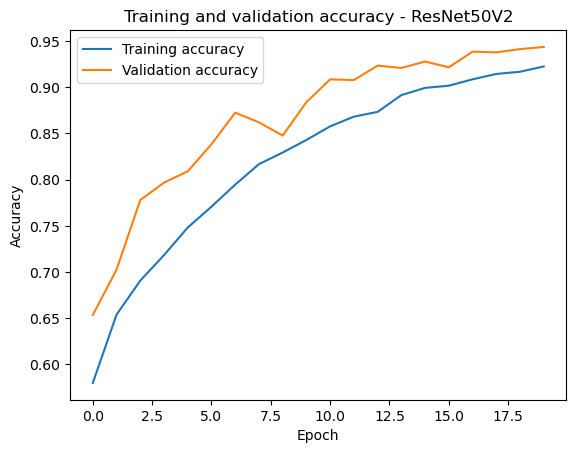

In [ ]:
# Plot training and validation accuracy
plt.plot(resNet_history.history["accuracy"], label="Training accuracy")
plt.plot(resNet_history.history["val_accuracy"], label="Validation accuracy")
plt.title("Training and validation accuracy - ResNet50V2")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()